# Pytorch中级实战(1): 使用YoloV3实现目标检测(Object Detection)

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# 工具函数

In [3]:
def convert_label_to_cxywh(image, label):
    """
    数据集中的label为(class_index, x_center, y_center, width, height)，且坐标都是小数。
    为了方便图形绘制，我们将中心点坐标转换为左上角坐标，同时将小数转换为整数
    """
    im_w, im_h = image.size(2), image.size(1)

    cxywh_list = []
    for obj in label:
        clazz_index, x_center, y_center, width, height = obj
        x = (x_center - width / 2) * im_w
        y = (y_center - height / 2) * im_h
        w = width * im_w
        h = height * im_h
        cxywh_list.append((clazz_index, x, y, w, h), )
    return cxywh_list

In [4]:
def im_show(image, label):
    """
    绘制图像及其中的物体边框
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    label = convert_label_to_cxywh(image, label)
    for obj in label:
        _, x, y, w, h = obj
        rect = plt.Rectangle(xy=(x, y), width=w, height=h, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

# 数据处理

In [5]:
image = torchvision.io.read_image('./coco/000000000009.jpg')

In [6]:
label = [
    [45, 0.479492, 0.688771, 0.955609, 0.5955],
    # [45, 0.736516, 0.247188, 0.498875, 0.476417],
    # [50, 0.637063, 0.732938, 0.494125, 0.510583],
    # [45, 0.339438, 0.418896, 0.678875, 0.7815],
    # [49, 0.646836, 0.132552, 0.118047, 0.096937],
    # [49, 0.773148, 0.129802, 0.090734, 0.097229],
    # [49, 0.668297, 0.226906, 0.131281, 0.146896],
    # [49, 0.642859, 0.079219, 0.148063, 0.148062],
]


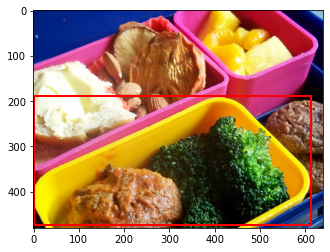

In [7]:
im_show(image, label)

In [8]:
image.size()

torch.Size([3, 480, 640])

In [9]:
# 注意，缩放图片并不需要对Label进行处理，因为label里面存的都是相对坐标。
transform = transforms.Resize((640, 640), )

In [10]:
image = transform(image)

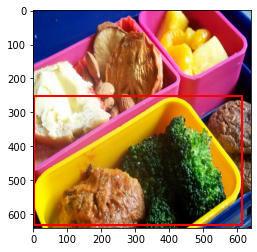

In [11]:
im_show(image, label)

In [12]:
# 对图片进行正则化
image = image / 255.

# 模型搭建

In [91]:
import pkg_resources as pkg


def check_version(current='0.0.0', minimum='0.0.0', name='version ', pinned=False, hard=False):
    # Check version vs. required version
    current, minimum = (pkg.parse_version(x) for x in (current, minimum))
    result = (current == minimum) if pinned else (current >= minimum)  # bool
    if hard:  # assert min requirements met
        assert result, f'{name}{minimum} required by YOLOv3, but {name}{current} is currently installed'
    else:
        return result

In [92]:
def autopad(k, p=None):  # kernel, padding
    # Pad to 'same'
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

In [93]:
class Conv(nn.Module):
    # Standard convolution
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, act=True):  # ch_in, ch_out, kernel, stride, padding, groups
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p), groups=g, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = nn.SiLU() if act is True else (act if isinstance(act, nn.Module) else nn.Identity())

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        return self.act(self.conv(x))

In [94]:
class Concat(nn.Module):
    # Concatenate a list of tensors along dimension
    def __init__(self, dimension=1):
        super().__init__()
        self.d = dimension

    def forward(self, x):
        return torch.cat(x, self.d)

In [147]:
class Detect(nn.Module):

    def __init__(self):
        super().__init__()
        self.n_anchors = 3
        self.n_outputs = 80 + 5  # 每个anchor输出的数量，80个类别+4个坐标+1个置信度

        self.m = nn.ModuleList(
            [
                nn.Conv2d(256, 255, 1, 1),
                nn.Conv2d(512, 255, 1, 1)
            ],
        )

    def forward(self, x):
        outputs = []
        for i in range(len(self.m)):
            # 最后输出两个不同尺度的TODO
            output = self.m[i](x[i])
            # 由于有3个anchor，所以需要将output的Shape从(batch_size, 255, 20, 20)转换为(batch_size, 3, 20 ,20, 85)
            bs, _, ny, nx = output.shape
            output = output.view(bs, self.n_anchors, self.n_outputs, ny, nx).permute(0, 1, 3, 4, 2).contiguous()

            outputs.append(output)
        return outputs

In [148]:
class YoloV3Tiny(nn.Module):

    def __init__(self):
        super(YoloV3Tiny, self).__init__()
        self.backbone_0 = Conv(3, 16, 3, 1)  # 0
        self.backbone_1 = nn.MaxPool2d(2, 2, 0)  # 1
        self.backbone_2 = Conv(16, 32, 3, 1)
        self.backbone_3 = nn.MaxPool2d(2, 2, 0)  # 3
        self.backbone_4 = Conv(32, 64, 3, 1)
        self.backbone_5 = nn.MaxPool2d(2, 2, 0)  # 5
        self.backbone_6 = Conv(64, 128, 3, 1)
        self.backbone_7 = nn.MaxPool2d(2, 2, 0)  # 7
        self.backbone_8 = Conv(128, 256, 3, 1)
        self.backbone_9 = nn.MaxPool2d(2, 2, 0)  # 9
        self.backbone_10 = Conv(256, 512, 3, 1)
        self.backbone_11 = nn.ZeroPad2d([0, 1, 0, 1])  # 11
        self.backbone_12 = nn.MaxPool2d(2, 1, 0)  # 12

        self.head_13 = Conv(512, 1024, 3, 1)
        self.head_14 = Conv(1024, 256, 1, 1)
        self.head_15 = Conv(256, 512, 3, 1)
        self.head_16 = Conv(256, 128, 1, 1)
        self.head_17 = nn.Upsample(None, 2, 'nearest')
        self.head_18 = Concat(1)
        self.head_19 = Conv(384, 256, 3, 1)
        self.head_20 = Detect()

    def forward(self, images):
        outputs = self.backbone_0(images)
        outputs = self.backbone_1(outputs)
        outputs = self.backbone_2(outputs)
        outputs = self.backbone_3(outputs)
        outputs = self.backbone_4(outputs)
        outputs = self.backbone_5(outputs)
        outputs = self.backbone_6(outputs)
        outputs = self.backbone_7(outputs)
        outputs_8 = self.backbone_8(outputs)
        outputs = self.backbone_9(outputs_8)
        outputs = self.backbone_10(outputs)
        outputs = self.backbone_11(outputs)
        outputs = self.backbone_12(outputs)

        outputs = self.head_13(outputs)
        outputs_14 = self.head_14(outputs)
        outputs_15 = self.head_15(outputs_14)
        outputs = self.head_16(outputs_14)
        outputs = self.head_17(outputs)
        outputs = self.head_18([outputs, outputs_8])
        outputs_19 = self.head_19(outputs)
        outputs = self.head_20([outputs_19, outputs_15])
        return outputs

In [149]:
model = YoloV3Tiny()

In [150]:
outputs = model(image.unsqueeze(0))

In [151]:
outputs[0].size()

torch.Size([1, 3, 40, 40, 85])

In [152]:
outputs[1].size()

torch.Size([1, 3, 20, 20, 85])

# 模型训练

In [155]:
BCEcls = nn.BCEWithLogitsLoss()
BCEobj = nn.BCEWithLogitsLoss()

# 模型推理

ModuleNotFoundError: No module named 'models'